In [1]:
import numpy as np
import polars as pl
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
df = pl.read_csv(
    "../../stats.csv",
    has_header=False,
    new_columns=[
        "lhs-id",
        "rhs-id",
        "n-residue-matches",
        "chain-length",
    ],
)

<Axes: xlabel='chain-length', ylabel='n-residue-matches'>

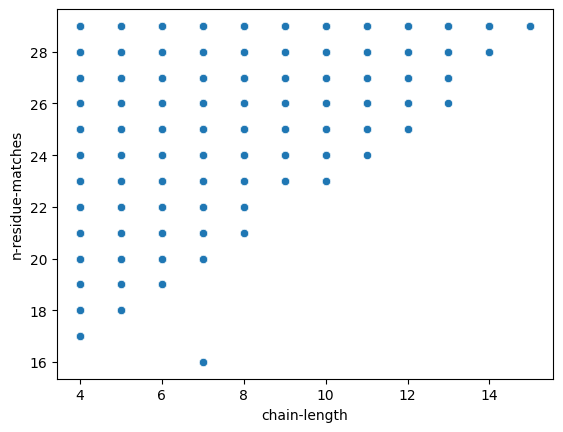

In [17]:
sns.scatterplot(
    df.to_pandas(),
    x="chain-length",
    y="n-residue-matches",
)

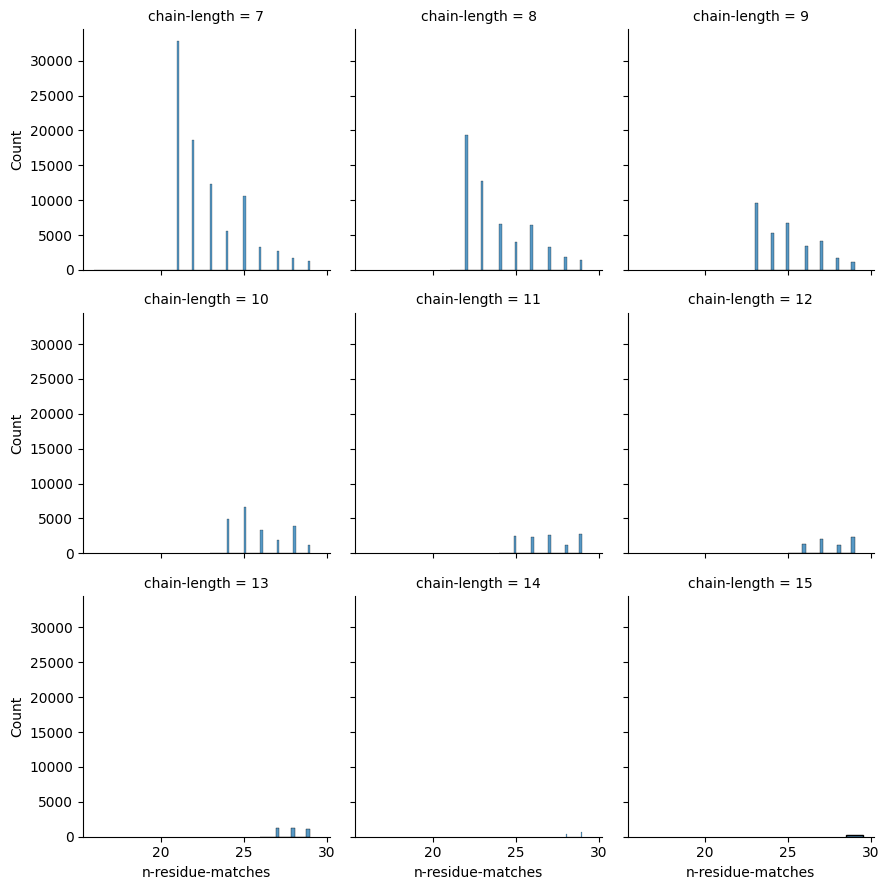

In [22]:
df.filter(pl.col("n-residue-matches") > 26)
g = sns.FacetGrid(df.filter(pl.col("chain-length") > 6).to_pandas(), col="chain-length", col_wrap=3)
g.map_dataframe(sns.histplot, x="n-residue-matches")
